In [1]:
!python -V

Python 3.9.0


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

In [6]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/05/19 17:03:12 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/Mateo/OneDrive/Documentos/github/mlops-zoomcamp/02-experiment_tracking/mlruns/1', creation_time=1747692192186, experiment_id='1', last_update_time=1747692192186, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [8]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')


df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.827368941909368

C:\Users\Mateo\AppData\Local\Temp\ipykernel_572\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\Mateo\AppData\Local\Temp\ipykernel_572\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


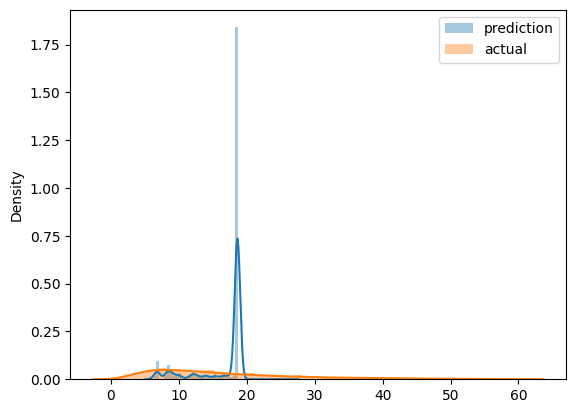

In [24]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [14]:
len(df_train), len(df_val)

(73908, 61921)

In [15]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [16]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715203341164

In [21]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### **MLFLOW**: Simple example on how to use MLFLOW

In [ ]:
with mlflow.start_run():

    mlflow.set_tag("developer","mateo")
    mlflow.log_param("train-data-path",'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
    mlflow.log_param("valid-data-path",'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

    alpha = 0.1
    mlflow.log_param("alpha",alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)



    mlflow.log_metric("rmse",rmse)

    # save the model
    mlflow.log_artifact(local_path="models/lin_reg.bin" , artifact_path="models_pickle")

--------------------------

## **MLFLOW**: Setting up for hyperparameter optimization

In [ ]:
# Libraries for bayesian hiperparameter optimization

import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope 



* dfmin: main function to minimize a loss function.

* tpe.suggest: the optimization algorithm (Tree-structured Parzen Estimator).

* hp: defines the hyperparameter search space.

* Trials: object to store information about each trial.

* STATUS_OK: status flag used by hyperopt.

### **MODEL**: Create the train and validation sets

In [36]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val,label=y_val)

In [ ]:
# Define the objective function 

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=55,
            evals=[(valid,"validation")],
            early_stopping_rounds=50,
        )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse",rmse)

    return {'loss':rmse,
            'status':STATUS_OK}

### **MODEL:** Define the search space

In [41]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth',4,100,1)),
    'learning_rate': hp.loguniform('learning_rate',-3,0), #  values between exp(-3) - exp(0) [0.05, 1]
    'reg_alpha' : hp.loguniform('reg_alpha',-5,-1),
    'reg_lambda': hp.loguniform('reg_lambda',-6,-1),
    'min_child_weight': hp.loguniform('min_child_weight',-1,3),
    'objective' : 'reg:linear',
    'seed' : 123
}

### **MODEL**: Finding the best model

In [42]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo = tpe.suggest,
    max_evals=10,
    trials=Trials() # Where the information will be stored
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [17:48:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.71995                          
[1]	validation-rmse:11.26704                          
[2]	validation-rmse:10.85010                          
[3]	validation-rmse:10.46673                          
[4]	validation-rmse:10.11520                          
[5]	validation-rmse:9.79261                           
[6]	validation-rmse:9.49975                           
[7]	validation-rmse:9.23067                           
[8]	validation-rmse:8.98787                           
[9]	validation-rmse:8.76425                           
[10]	validation-rmse:8.56129                          
[11]	validation-rmse:8.37780                          
[12]	validation-rmse:8.21170                          
[13]	validation-rmse:8.05910                          
[14]	validation-rmse:7.92252                          
[15]	validation-rmse:7.79946                          
[16]	validation-rmse:7.68547                          
[17]	validation-rmse:7.58322                          
[18]	valid

c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.48636                                                     
[1]	validation-rmse:8.04366                                                     
[2]	validation-rmse:7.32381                                                     
[3]	validation-rmse:6.96654                                                     
[4]	validation-rmse:6.78904                                                     
[5]	validation-rmse:6.69398                                                     
[6]	validation-rmse:6.63375                                                     
[7]	validation-rmse:6.59640                                                     
[8]	validation-rmse:6.57387                                                     
[9]	validation-rmse:6.55623                                                     
[10]	validation-rmse:6.54463                                                    
[11]	validation-rmse:6.53024                                                    
[12]	validation-rmse:6.51970

c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [17:50:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.45085                                                   
[1]	validation-rmse:10.78576                                                   
[2]	validation-rmse:10.20564                                                   
[3]	validation-rmse:9.69660                                                    
[4]	validation-rmse:9.25978                                                    
[5]	validation-rmse:8.87660                                                    
[6]	validation-rmse:8.54995                                                    
[7]	validation-rmse:8.26512                                                    
[8]	validation-rmse:8.02566                                                    
[9]	validation-rmse:7.81989                                                    
[10]	validation-rmse:7.63468                                                   
[11]	validation-rmse:7.48599                                                   
[12]	validation-rmse:7.35880            

c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.49370                                                    
[1]	validation-rmse:9.27163                                                     
[2]	validation-rmse:8.42263                                                     
[3]	validation-rmse:7.84323                                                     
[4]	validation-rmse:7.45331                                                     
[5]	validation-rmse:7.19001                                                     
[6]	validation-rmse:7.01476                                                     
[7]	validation-rmse:6.89697                                                     
[8]	validation-rmse:6.81390                                                     
[9]	validation-rmse:6.75757                                                     
[10]	validation-rmse:6.71176                                                    
[11]	validation-rmse:6.68020                                                    
[12]	validation-rmse:6.65553

c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.60555                                                   
[1]	validation-rmse:11.05808                                                   
[2]	validation-rmse:10.56666                                                   
[3]	validation-rmse:10.12645                                                   
[4]	validation-rmse:9.73329                                                    
[5]	validation-rmse:9.38410                                                    
[6]	validation-rmse:9.07222                                                    
[7]	validation-rmse:8.79622                                                    
[8]	validation-rmse:8.55148                                                    
[9]	validation-rmse:8.33491                                                    
[10]	validation-rmse:8.14421                                                   
[11]	validation-rmse:7.97578                                                   
[12]	validation-rmse:7.82775            

c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.47222                                                   
[1]	validation-rmse:10.82205                                                   
[2]	validation-rmse:10.25116                                                   
[3]	validation-rmse:9.74933                                                    
[4]	validation-rmse:9.31767                                                    
[5]	validation-rmse:8.93863                                                    
[6]	validation-rmse:8.61452                                                    
[7]	validation-rmse:8.33094                                                    
[8]	validation-rmse:8.08939                                                    
[9]	validation-rmse:7.88396                                                    
[10]	validation-rmse:7.70596                                                   
[11]	validation-rmse:7.54902                                                   
[12]	validation-rmse:7.41856            

c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.19095                                                    
[1]	validation-rmse:6.76149                                                    
[2]	validation-rmse:6.70537                                                    
[3]	validation-rmse:6.69635                                                    
[4]	validation-rmse:6.68881                                                    
[5]	validation-rmse:6.68814                                                    
[6]	validation-rmse:6.68530                                                    
[7]	validation-rmse:6.67736                                                    
[8]	validation-rmse:6.67305                                                    
[9]	validation-rmse:6.66750                                                    
[10]	validation-rmse:6.66502                                                   
[11]	validation-rmse:6.65808                                                   
[12]	validation-rmse:6.65404            

c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.70887                                                   
[1]	validation-rmse:11.24547                                                   
[2]	validation-rmse:10.82051                                                   
[3]	validation-rmse:10.43156                                                   
[4]	validation-rmse:10.07562                                                   
[5]	validation-rmse:9.75051                                                    
[6]	validation-rmse:9.45398                                                    
[7]	validation-rmse:9.18390                                                    
[8]	validation-rmse:8.93850                                                    
[9]	validation-rmse:8.71637                                                    
[10]	validation-rmse:8.51499                                                   
[11]	validation-rmse:8.33245                                                   
[12]	validation-rmse:8.16752            

c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [17:56:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.52490                                                   
[1]	validation-rmse:10.91334                                                   
[2]	validation-rmse:10.37224                                                   
[3]	validation-rmse:9.89449                                                    
[4]	validation-rmse:9.47391                                                    
[5]	validation-rmse:9.10473                                                    
[6]	validation-rmse:8.78222                                                    
[7]	validation-rmse:8.50010                                                    
[8]	validation-rmse:8.25486                                                    
[9]	validation-rmse:8.04149                                                    
[10]	validation-rmse:7.85646                                                   
[11]	validation-rmse:7.69622                                                   
[12]	validation-rmse:7.55763            

c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [17:57:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.82709                                                   
[1]	validation-rmse:9.76099                                                    
[2]	validation-rmse:8.95050                                                    
[3]	validation-rmse:8.34140                                                    
[4]	validation-rmse:7.89022                                                    
[5]	validation-rmse:7.55866                                                    
[6]	validation-rmse:7.31642                                                    
[7]	validation-rmse:7.13964                                                    
[8]	validation-rmse:7.00836                                                    
[9]	validation-rmse:6.91178                                                    
[10]	validation-rmse:6.83979                                                   
[11]	validation-rmse:6.78643                                                   
[12]	validation-rmse:6.74572            

### **MODEL**: Using the best model

In [46]:
mlflow.xgboost.autolog(disable=True)


In [43]:
params = {
    'max_depth': 84,
    'learning_rate': 0.06248648809504339,
    'reg_alpha' : 0.01868809980419891,
    'reg_lambda': 0.08788616023689615,
    'min_child_weight': 3.4431892558874027,
    'objective' : 'reg:linear',
    'seed' : 123
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=55,
    evals=[(valid,"validation")],
    early_stopping_rounds=50,
)

2025/05/19 18:07:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7e0a0d6f6d9c42dba0a2ce45fb3a552d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [18:07:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.70393
[1]	validation-rmse:11.23536
[2]	validation-rmse:10.80481
[3]	validation-rmse:10.40988
[4]	validation-rmse:10.04783
[5]	validation-rmse:9.71711
[6]	validation-rmse:9.41530
[7]	validation-rmse:9.14004
[8]	validation-rmse:8.88961
[9]	validation-rmse:8.66161
[10]	validation-rmse:8.45457
[11]	validation-rmse:8.26703
[12]	validation-rmse:8.09712
[13]	validation-rmse:7.94369
[14]	validation-rmse:7.80446
[15]	validation-rmse:7.67864
[16]	validation-rmse:7.56531
[17]	validation-rmse:7.46289
[18]	validation-rmse:7.37013
[19]	validation-rmse:7.28677
[20]	validation-rmse:7.21142
[21]	validation-rmse:7.14377
[22]	validation-rmse:7.08197
[23]	validation-rmse:7.02709
[24]	validation-rmse:6.97765
[25]	validation-rmse:6.93290
[26]	validation-rmse:6.89304
[27]	validation-rmse:6.85624
[28]	validation-rmse:6.82282
[29]	validation-rmse:6.79214
[30]	validation-rmse:6.76428
[31]	validation-rmse:6.73991
[32]	validation-rmse:6.71674
[33]	validation-rmse:6.69590
[34]	validation-rms

2025/05/19 18:10:36 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/19 18:10:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [18:10:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/19 18:10:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### **MLFLOW**: Saving the model and the preprocessor

In [47]:
with mlflow.start_run():

    best_params = {
        'max_depth': 84,
        'learning_rate': 0.06248648809504339,
        'reg_alpha' : 0.01868809980419891,
        'reg_lambda': 0.08788616023689615,
        'min_child_weight': 3.4431892558874027,
        'objective' : 'reg:linear',
        'seed' : 123
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=55,
        evals=[(valid,"validation")],
        early_stopping_rounds=50,
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse",rmse)
    

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [18:59:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.70393
[1]	validation-rmse:11.23536
[2]	validation-rmse:10.80481
[3]	validation-rmse:10.40988
[4]	validation-rmse:10.04783
[5]	validation-rmse:9.71711
[6]	validation-rmse:9.41530
[7]	validation-rmse:9.14004
[8]	validation-rmse:8.88961
[9]	validation-rmse:8.66161
[10]	validation-rmse:8.45457
[11]	validation-rmse:8.26703
[12]	validation-rmse:8.09712
[13]	validation-rmse:7.94369
[14]	validation-rmse:7.80446
[15]	validation-rmse:7.67864
[16]	validation-rmse:7.56531
[17]	validation-rmse:7.46289
[18]	validation-rmse:7.37013
[19]	validation-rmse:7.28677
[20]	validation-rmse:7.21142
[21]	validation-rmse:7.14377
[22]	validation-rmse:7.08197
[23]	validation-rmse:7.02709
[24]	validation-rmse:6.97765
[25]	validation-rmse:6.93290
[26]	validation-rmse:6.89304
[27]	validation-rmse:6.85624
[28]	validation-rmse:6.82282
[29]	validation-rmse:6.79214
[30]	validation-rmse:6.76428
[31]	validation-rmse:6.73991
[32]	validation-rmse:6.71674
[33]	validation-rmse:6.69590
[34]	validation-rms

c:\Users\Mateo\miniconda3\envs\mlopsw2\lib\site-packages\xgboost\core.py:158: UserWarning: [19:02:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/19 19:02:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


-----------

### **MLFLOW**: Making predictions with the MLFLOW Artifacts

In [48]:
model_uri = 'runs:/7fedd2aa61ee4659b8c2303ce3c0ad57/models_mlflow'

loaded_model = mlflow.pyfunc.load_model(model_uri)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 7fedd2aa61ee4659b8c2303ce3c0ad57

We can also import the model as XGBoost directly

In [49]:
xgboost_model = mlflow.xgboost.load_model(model_uri)
xgboost_model

In [52]:
y_pred = xgboost_model.predict(valid)
rmse = mean_squared_error(y_val, y_pred)
rmse**(1/2)

6.498726287114662